#Imports

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import pandas as pd
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import wandb
wandb.login(key='1ee7845713d1303ac1abff70cf959518e1ae311c')
wandb.init(project="cs6910_RNN")
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import csv
import heapq
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
from IPython.display import clear_output

#dataset Loading and preprocessing

In [5]:
class Dataset:
    def __init__(self,filepath):
        self.X=[]
        self.Y=[]
        self.input_corpus= set()
        self.output_corpus= set()
        csv_file=open(filepath)
        my_csv=csv.reader(csv_file)
        for i in my_csv:   
            self.X.append(i[0])
            self.Y.append(i[1])
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)

    def add_start_end_tokens(self):
        for i in range(self.Y.shape[0]):
            self.Y[i] = "\t" + self.Y[i] + "\n"
        return self.X,self.Y

    def get_input_corpus(self):
        for word in self.X:
            for char in word:
                if char not in self.input_corpus:
                    self.input_corpus.add(char)

        self.input_corpus.add(" ")
        self.input_corpus = sorted(list(self.input_corpus))
        return self.input_corpus

    def get_output_corpus(self):
        for word in self.Y:
            for char in word:
                if char not in self.output_corpus:
                    self.output_corpus.add(char)
        self.output_corpus.add(" ")
        self.output_corpus = sorted(list(self.output_corpus))
        return self.output_corpus





In [6]:
train_data=Dataset("/kaggle/input/a3data/hin_train.csv") 
train_X,train_Y=train_data.add_start_end_tokens()

valid_data=Dataset("/kaggle/input/a3data/hin_valid.csv")
val_X,val_Y=valid_data.add_start_end_tokens()

test_data=Dataset("/kaggle/input/a3data/hin_test.csv")
test_X,test_Y=test_data.add_start_end_tokens()


print("size of the training data",len(train_X),len(train_Y))
print("size of the validation data",len(val_X),len(val_Y))
print("size of the training data",len(test_X),len(test_Y))
    

In [7]:


input_corpus = train_data.get_input_corpus()
output_corpus = train_data.get_output_corpus()

num_encoder_tokens = len(input_corpus)
num_decoder_tokens = len(output_corpus)
#The lengths represent the count of unique characters in the input(encoder) and output sequences(decoder),
#serving as the vocabulary size for each part.
print(input_corpus)
print(output_corpus)

In [9]:
max_encoder_seq_length = max([len(txt) for txt in train_X]) + 2
max_decoder_seq_length = max([len(txt) for txt in train_Y])


In [12]:
# Create the input character index dictionary
input_char_index = {}
for i, char in enumerate(input_corpus):
    input_char_index[char] = i

# Create the output character index dictionary
output_char_index = {}
for i, char in enumerate(output_corpus):
    output_char_index[char] = i

In [13]:


def populate_data_arrays(data_X, data_Y, input_char_index, output_char_index, max_encoder_seq_length, max_decoder_seq_length):
    num_samples = len(data_X)
    input_data = np.zeros((max_encoder_seq_length + 1, num_samples), dtype="int64")
    target_data = np.zeros((max_decoder_seq_length + 1, num_samples), dtype="int64")
    
    for i, (x, y) in enumerate(zip(data_X, data_Y)):
        for t, char in enumerate(x):
            input_data[t, i] = input_char_index[char]
        input_data[t + 1:, i] = input_char_index[" "]
        
        for t, char in enumerate(y):
            target_data[t, i] = output_char_index[char]
        target_data[t + 1:, i] = output_char_index[" "]
    
    return input_data, target_data

# Usage:
input_data, target_data = populate_data_arrays(train_X, train_Y, input_char_index, output_char_index,
                                               max_encoder_seq_length, max_decoder_seq_length)
input_data_val, target_data_val = populate_data_arrays(val_X, val_Y, input_char_index, output_char_index,
                                                       max_encoder_seq_length, max_decoder_seq_length)


In [14]:
# convertin numpy arrays to tensors
input_data = torch.tensor(input_data,dtype=torch.int64)
target_data = torch.tensor(target_data,dtype=torch.int64)
input_data_val = torch.tensor(input_data_val,dtype=torch.int64)
target_data_val = torch.tensor(target_data_val,dtype=torch.int64)
print(input_data.shape,target_data.shape,input_data_val.shape,target_data_val.shape)

In [ ]:
# Create the reverse input character index dictionary
reverse_input_char_index = {}
for char, i in input_char_index.items():
    reverse_input_char_index[i] = char

# Create the reverse output character index dictionary
reverse_target_char_index = {}
for char, i in output_char_index.items():
    reverse_target_char_index[i] = char

#lstm with attention

In [15]:
#Enoder LSTM Class
class EncoderLSTM(nn.Module):
    """
    A LSTM encoder for sequence-to-sequence learning.
    Args:
        inp_vocab_size (int): The size of the input vocabulary.
        embedding_size (int): The size of the embedding layer.
        hidden_size (int): The size of the hidden state.
        num_layers (int): The number of GRU layers.
        p (float): The dropout rate.

    """
    def __init__(self, inp_vocab_size, embedding_size, hidden_size, num_layers, d):
        super(EncoderLSTM, self).__init__()
        # Store the input parameters        
        self.num_layers = num_layers
        self.dropout = nn.Dropout(d)
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size

        # Define the embedding layer
        self.cell_type="LSTM"
        self.embedding = nn.Embedding(inp_vocab_size, embedding_size)

        # Define the LSTM layer
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=d)

    def forward(self, inpx):
        """
        Encodes a sequence of input tokens.

        Args:
        x (torch.Tensor): A tensor of shape (seq_length, batch_size).

        Returns:
        torch.Tensor: The hidden state of the GRU, of shape (num_layers, batch_size, hidden_size).

        """
        # Apply dropout to the input
        embedded_inp=self.embedding(inpx)
        embedded_inp_drop = self.dropout(embedded_inp)

        # Pass the embedded input through the LSTM layer
        outputs, (hiddenstate, cellstate) = self.rnn(embedded_inp_drop)

        return outputs,hiddenstate, cellstate



#Deoder LSTM class
class DecoderLSTM(nn.Module):
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p,max_length=max_encoder_seq_length):
        super(DecoderLSTM, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.max_length=max_length
        self.output_size=output_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.attn = nn.Linear(self.hidden_size +embedding_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size +embedding_size, self.hidden_size)
 
        self.rnn = nn.LSTM(self.hidden_size, self.hidden_size)
    
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden,cell,encoder_outputs):
        #embedded = self.embedding(input).view(1, 1, -1)
        
        input=input.unsqueeze(1).transpose(0,1)
        embedded=self.embedding(input)
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),encoder_outputs.permute(1,0,2))
        output = torch.cat((embedded[0], attn_applied.squeeze(1)), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        
    
        #output, hidden = self.rnn(output, hidden)
        
        outputs, (hidden, cell) = self.rnn(output, (hidden, cell))
        
        output=self.out(output.squeeze(0))
        return output, hidden, cell,attn_weights



class Seq2SeqLSTM(nn.Module):
    """
    A sequence-to-sequence model with a GRU encoder and decoder.
    Args:
        encoder (EncoderGRU): The encoder.
        decoder (DecoderGRU): The decoder.
    """
    def __init__(self, encoder, decoder):
        super(Seq2SeqLSTM, self).__init__()

        # Store the encoder and decoder modules
        self.encoder = encoder
        self.decoder = decoder
        

    def forward(self, source, target, teacher_force_ratio=0.2):
        """
        Performs forward propagation on the model.

        Args:
            source (torch.Tensor): A tensor of shape (seq_length, batch_size).
            target (torch.Tensor): A tensor of shape (target_len, batch_size).
            teacher_force_ratio (float): The probability of using teacher forcing.

        Returns:
            torch.Tensor: A tensor of shape (target_len, batch_size, output_size).

        """
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = num_decoder_tokens

        # Initialize the outputs tensor
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

        # Encode the source sequence
        hidden_state, cell_state = self.encoder(source)

        # Initialize the input to the decoder with the start token
        input_token = target[0]

        # Initialize the counter variable
        t = 1

        # Iterate over the target sequence length
        while t < target_len:
            # Pass the input, hidden state, and cell state through the decoder
            decoder_output, hidden_state, cell_state,attn_weights = self.decoder(input_token, hidden_state, cell_state)

            # Store the decoder output in the outputs tensor
            outputs[t] = decoder_output

            # Determine the next input to the decoder using teacher forcing
            if random.random() < teacher_force_ratio:
                input_token = target[t]
            else:
                input_token = decoder_output.argmax(1)

            # Increment the counter
            t += 1

        return outputs



#GRU with attention

In [16]:
# EncoderGRU class
class EncoderGRU(nn.Module):
    """
    A GRU encoder for sequence-to-sequence learning.

    Args:
        inp_vocab_size (int): The size of the input vocabulary.
        embedding_size (int): The size of the embedding layer.
        hidden_size (int): The size of the hidden state.
        num_layers (int): The number of GRU layers.
        p (float): The dropout rate.

    """

    def __init__(self, inp_vocab_size, embedding_size, hidden_size, num_layers, p=0.3):
        super(EncoderGRU, self).__init__()

        # Dropout layer.
        self.dropout = nn.Dropout(p)

        # Embedding layer.
        self.embedding = nn.Embedding(inp_vocab_size, embedding_size)

        # GRU layer.
        self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, dropout=p)

    def forward(self, inpx):
        """
        Encodes a sequence of input tokens.

        Args:
            x (torch.Tensor): A tensor of shape (seq_length, batch_size).

        Returns:
            torch.Tensor: The hidden state of the GRU, of shape (num_layers, batch_size, hidden_size).

        """

        # Embedding layer.
        embedded_inpx=self.embedding(inpx)
        embedded_inpx_drop = self.dropout(embedded_inpx)

        # GRU layer.
        outputs, hidden = self.rnn(embedded_inpx_drop)

        return outputs,hidden


# DecoderGRU class
class DecoderGRU(nn.Module):
    """
    A GRU decoder for sequence-to-sequence learning.

    Args:
        inp_vocab_size (int): The size of the input vocabulary.
        embedding_size (int): The size of the embedding layer.
        hidden_size (int): The size of the hidden state.
        output_size (int): The size of the output vocabulary.
        num_layers (int): The number of GRU layers.
        p (float): The dropout rate.

    """

    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p,max_length=max_encoder_seq_length):
        super(DecoderGRU, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.max_length=max_length
        self.output_size=output_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.attn = nn.Linear(self.hidden_size +embedding_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size +embedding_size, self.hidden_size)
 
        self.rnn = nn.GRU(self.hidden_size, self.hidden_size)
    
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden,encoder_outputs):
        #embedded = self.embedding(input).view(1, 1, -1)
        input=input.unsqueeze(1).transpose(0,1)
        embedded=self.embedding(input)
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),encoder_outputs.permute(1,0,2))
        output = torch.cat((embedded[0], attn_applied.squeeze(1)), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        
    
        output, hidden = self.rnn(output, hidden)
        output=self.out(output.squeeze(0))
        return output, hidden, attn_weights


# Seq2SeqGRU class
class Seq2SeqGRU(nn.Module):
    """
    A sequence-to-sequence model with a GRU encoder and decoder.

    Args:
        encoder (EncoderGRU): The encoder.
        decoder (DecoderGRU): The decoder.

    """

    def __init__(self, encoder, decoder):
        super(Seq2SeqGRU, self).__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.3):
        """
        Performs forward propagation on the model.

        Args:
            source (torch.Tensor): A tensor of shape (seq_length, batch_size).
            target (torch.Tensor): A tensor of shape (target_len, batch_size).
            teacher_force_ratio (float): The probability of using teacher forcing.

        Returns:
            torch.Tensor: A tensor of shape (target_len, batch_size, output_size).

        """
        # Encode the source sequence.
        hidden = self.encoder(source)
        # Initialize the decoder hidden state.
        decoder_hidden = hidden


        # Initialize the output predictions.
        predictions = torch.zeros(target.shape[0], source.shape[1],num_decoder_tokens ).to(device)

        # Initialize the counter variable.
        t = 0

        x=target[0]
        # Loop over the target sequence.
        while t < target.shape[0]:

            # Decode the next output token.
            output, decoder_hidden,attn_weights = self.decoder(x, decoder_hidden)

            # Store the output prediction.
            predictions[t] = output

            # Get the next input to the decoder.
            x = target[t] if random.random() < teacher_force_ratio else predictions[t].argmax(1)

            # Increment the counter.
            t += 1

        return predictions

#RNN with attention

In [17]:
# EncoderGRU class
class EncoderRNN(nn.Module):
    """
    A RNN encoder for sequence-to-sequence learning.

    Args:
        inp_vocab_size (int): The size of the input vocabulary.
        embedding_size (int): The size of the embedding layer.
        hidden_size (int): The size of the hidden state.
        num_layers (int): The number of RNN layers.
        p (float): The dropout rate.

    """

    def __init__(self, inp_vocab_size, embedding_size, hidden_size, num_layers, p=0.3):
        super(EncoderRNN, self).__init__()

        # Dropout layer.
        self.dropout = nn.Dropout(p)

        # Embedding layer.
        self.embedding = nn.Embedding(inp_vocab_size, embedding_size)

        # GRU layer.
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout=p)

    def forward(self, inpx):
        """
        Encodes a sequence of input tokens.

        Args:
            x (torch.Tensor): A tensor of shape (seq_length, batch_size).

        Returns:
            torch.Tensor: The hidden state of the RNN, of shape (num_layers, batch_size, hidden_size).

        """

        # Embedding layer.
        embedded_inpx=self.embedding(inpx)
        embedded_inpx_drop = self.dropout(embedded_inpx)

        # GRU layer.
        outputs, hidden = self.rnn(embedded_inpx_drop)

        return outputs,hidden


# DecoderRNN class
class DecoderRNN(nn.Module):
    """
    A GRU decoder for sequence-to-sequence learning.

    Args:
        inp_vocab_size (int): The size of the input vocabulary.
        embedding_size (int): The size of the embedding layer.
        hidden_size (int): The size of the hidden state.
        output_size (int): The size of the output vocabulary.
        num_layers (int): The number of GRU layers.
        p (float): The dropout rate.

    """

    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p,max_length=max_encoder_seq_length):
        super(DecoderRNN, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.max_length=max_length
        self.output_size=output_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.attn = nn.Linear(self.hidden_size +embedding_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size +embedding_size, self.hidden_size)
 
        self.rnn = nn.RNN(self.hidden_size, self.hidden_size)
    
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden,encoder_outputs):
        #embedded = self.embedding(input).view(1, 1, -1)
        input=input.unsqueeze(1).transpose(0,1)
        embedded=self.embedding(input)
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),encoder_outputs.permute(1,0,2))
        output = torch.cat((embedded[0], attn_applied.squeeze(1)), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        #print(output.shape,hidden.shape)
        output, hidden = self.rnn(output, hidden)
        output=self.out(output.squeeze(0))
        return output, hidden, attn_weights


# Seq2SeqRNN class
class Seq2SeqRNN(nn.Module):
    """
    A sequence-to-sequence model with a RNN encoder and decoder.

    Args:
        encoder (EncoderGRU): The encoder.
        decoder (DecoderGRU): The decoder.

    """

    def __init__(self, encoder, decoder):
        super(Seq2SeqRNN, self).__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.3):
        """
        Performs forward propagation on the model.

        Args:
            source (torch.Tensor): A tensor of shape (seq_length, batch_size).
            target (torch.Tensor): A tensor of shape (target_len, batch_size).
            teacher_force_ratio (float): The probability of using teacher forcing.

        Returns:
            torch.Tensor: A tensor of shape (target_len, batch_size, output_size).

        """
        # Encode the source sequence.
        hidden = self.encoder(source)
        # Initialize the decoder hidden state.
        decoder_hidden = hidden


        # Initialize the output predictions.
        predictions = torch.zeros(target.shape[0], source.shape[1],num_decoder_tokens ).to(device)

        # Initialize the counter variable.
        t = 0

        x=target[0]
        # Loop over the target sequence.
        while t < target.shape[0]:

            # Decode the next output token.
            output, decoder_hidden,attn_weights = self.decoder(x, decoder_hidden)

            # Store the output prediction.
            predictions[t] = output

            # Get the next input to the decoder.
            x = target[t] if random.random() < teacher_force_ratio else predictions[t].argmax(1)

            # Increment the counter.
            t += 1

        return predictions

#BeamSearchGR

In [ ]:
def initialiser(len):
    return np.zeros((len,1),dtype="int64")

In [ ]:
def beam_searchLSTM(model, word, input_char_idx, output_char_idx, reverse_input_char_idx,
                reverse_target_char_idx, max_encoder_seq_len, max_decoder_seq_len,
                encoder_tok_numbers, decoder_tok_numbers, beam_width, device, length_penalty=0.6):

    # Initialize the output word
    word_t = ''

    # Encode the input word
    data = initialiser(max_encoder_seq_len)
    t = 0
    
    while t < len(word):
        char = word[t]
        data[t, 0] = input_char_idx[char]
        t += 1

        
    data[t :, 0] = input_char_idx[" "]
    
    
    mydata_type=torch.int64
    data = torch.tensor(data, dtype=mydata_type).to(device)

    
    with torch.no_grad():
        hidden, cell = model.encoder(data)

    # Initialize beam
    mychar=output_char_idx['\t']
    initial_sequence = torch.tensor(np.array(mychar).reshape(1,)).to(device)
    initial_hidden=hidden.unsqueeze(0)
    beam = [(0.0, initial_sequence,initial_hidden )]  # [(score, sequence, hidden)]

    
    time_step = 0
    while time_step < max_decoder_seq_len:
        candidates = []
        idx = 0
        while idx < len(beam):
            score, seq, hidden = beam[idx]
            last_token = seq[-1].item()
            if last_token == output_char_idx['\n']:
                # If the sequence ends with the end token, add it to the candidates
                candidates.append((score, seq, hidden))
                idx += 1
                continue

            x = torch.tensor(np.array(last_token).reshape(1,)).to(device)
            var=hidden.squeeze(0)
            output, hidden, cell,attnweights = model.decoder(x, var , cell)
            probabilities = F.softmax(output, dim=1)

            # Get the top-k probabilities and tokens
            topk_probs, topk_tokens = torch.topk(probabilities, k=beam_width)

            j = 0
            while j < len(topk_probs[0]):
                prob, token = topk_probs[0][j], topk_tokens[0][j]
                
                var2=token.unsqueeze(0)
                new_seq = torch.cat((seq,var2 ), dim=0)
                
                new_hidden = hidden.clone().unsqueeze(0)
                
                length_penalty_factor = ((len(new_seq) - 1) / 5) ** length_penalty  # Adjust penalty factor as needed
                myitem=torch.log(prob).item()
                candidates.append((score + myitem / length_penalty_factor, new_seq, new_hidden))
                j += 1

            idx += 1

        # Select top-k candidates based on the accumulated scores
        #beam = heapq.nlargest(beam_width, candidates, key=lambda x: x[0])
        def get_score(item):
            return item[0]

        # Use heapq.nlargest to retrieve the top candidates based on score
        beam = heapq.nlargest(beam_width, candidates, key=get_score)

        time_step += 1

    # Select the best sequence from the beam as the output
    #best_score, best_sequence, tempvar = max(beam, key=lambda x: x[0])
    
    best_score = float('-inf')
    best_sequence = None
    tempvar = None
    for item in beam:
        score = item[0]
        sequence = item[1]
        if score > best_score:
            best_score = score
            best_sequence = sequence
            tempvar = item[2]
    
    
    translated_word = ''
    for token in best_sequence[1:-1]:
        translated_word += reverse_target_char_idx[token.item()]

    return translated_word


In [19]:
def beam_searchGRU_RNN(model, input_word, input_char_dict, output_char_dict, reverse_input_char_dict,
                  reverse_output_char_dict, max_encoder_length, max_decoder_length,
                  encoder_tok_numbers, decoder_tok_numbers, beam_width, device, length_penalty=0.6):

    decoded_word = ''

    # Encode the input word
    encoder_input = initialiser(max_encoder_length)

    t = 0
    while t < len(input_word):
        encoder_input[t, 0] = input_char_dict[input_word[t]]
        t += 1

    encoder_input[t:, 0] = input_char_dict[" "]
    
    mydata_type=torch.int64
    encoder_input = torch.tensor(encoder_input, dtype=mydata_type).to(device)

    with torch.no_grad():
        hidden = model.encoder(encoder_input)

    # Initialize beam
    mychar=output_char_dict['\t']
    initial_sequence = torch.tensor(np.array(mychar).reshape(1,)).to(device)
    beam = [(0.0, initial_sequence, hidden.unsqueeze(0))]  # [(score, sequence, hidden)]

    time_step = 0
    while time_step < max_decoder_length:
        candidates = []
        for score, seq, hidden in beam:
            last_token = seq[-1].item()
            if last_token == output_char_dict['\n']:
                # If the sequence ends with the end token, add it to the candidates
                candidates.append((score, seq, hidden))
                continue

            x = torch.tensor(np.array(last_token).reshape(1,)).to(device)
            initial_hidden=hidden.squeeze(0)
            output, hidden,attn_weights = model.decoder(x, initial_hidden)
            probabilities = F.softmax(output, dim=1)

            # Get the top-k probabilities and tokens
            topk_probs, topk_tokens = torch.topk(probabilities, k=beam_width)

            for prob, token in zip(topk_probs[0], topk_tokens[0]):
                unsqueeze_token=token.unsqueeze(0)
                new_seq = torch.cat((  seq, unsqueeze_token   ), dim=0)
                new_hidden = hidden.clone().unsqueeze(0)
                length_penalty_factor = ((len(new_seq) - 1) / 5) ** length_penalty  # Adjust penalty factor as needed
                myitem=torch.log(prob).item()
                candidates.append((score + myitem / length_penalty_factor, new_seq, new_hidden))

        # Select top-k candidates based on the accumulated scores
        #beam = heapq.nlargest(beam_width, candidates, key=lambda x: x[0])
        # Define a custom comparison key function
        def get_score(item):
            return item[0]

        # Use heapq.nlargest to retrieve the top candidates based on score
        beam = heapq.nlargest(beam_width, candidates, key=get_score)

        time_step += 1

    # Select the best sequence from the beam as the output
    #best_score, best_sequence, tempvar = max(beam, key=lambda x: x[0])
    
    best_score = float('-inf')
    best_sequence = None
    tempvar = None
    for item in beam:
        score = item[0]
        sequence = item[1]
        if score > best_score:
            best_score = score
            best_sequence = sequence
            tempvar = item[2]
    
    translated_word = ''
    
    for token in best_sequence[1:-1]:
        translated_word += reverse_output_char_dict[token.item()]

    return translated_word


#Setting up some initial parameters

In [27]:
num_epochs = 2
learning_rate = 0.001
encoder_embedding_size = 256
input_size_decoder = num_decoder_tokens
batch_size = 32
load_model = False
num_enc_layers = 2
input_size_encoder = num_encoder_tokens
num_epochs = 2
learning_rate = 0.001
input_size_decoder = num_decoder_tokens
batch_size = 32
output_size = num_decoder_tokens

decoder_embedding_size = 256
hidden_size = 256  # Needs to be the same for both RNN's

num_dec_layers = 2
dropout=0.1
training = False

#Training

In [28]:
def training_function(num_encoder_tokens,input_embedding_size, dp, cell_type, hidden_size, num_enc_layers, num_dec_layers,num_epochs,       output_size,    input_size_decoder,     batch_size,beam_width):
    if(cell_type=="LSTM"):
        print("hello1")
        encoder_net = EncoderLSTM(input_size_encoder,input_embedding_size, hidden_size, num_enc_layers,dp).to(device)
        print("hello2")
        decoder_net = DecoderLSTM(input_size_decoder,input_embedding_size,hidden_size,output_size,num_dec_layers,dp).to(device)
        print("hello3")
        model = Seq2SeqLSTM(encoder_net, decoder_net).to(device)
        print("hello")
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        
        train_ds_x = torch.split(input_data,batch_size,dim=1)
        train_ds_y = torch.split(target_data,batch_size,dim=1)
        #print(train_ds_x)
        
        for epoch in range(num_epochs):
            print(f"[Epoch {epoch} / {num_epochs}]")
            #wandb.log({'epochs' : epoch})##############################
            
            total_loss=0#############################

            model.eval()
            model.train()

            for i, (x,y) in enumerate(zip(train_ds_x,train_ds_y)):
        # Get input and targets and get to cuda
                inp_data = x.to(device)
                target = y.to(device)

            # Forward prop
                output = model(inp_data, target)


                output = output[1:].reshape(-1, output.shape[2])
                target = target[1:].reshape(-1)

                optimizer.zero_grad()
                loss = criterion(output, target)
                total_loss += loss#########################
                

            # Back prop
                loss.backward()

            # Clip to avoid exploding gradient issues, makes sure grads are
            # within a healthy range
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            # Gradient descent step
                optimizer.step()
                
            ###################################################################################################################
#             total_words = len(train_X)
#             correct_pred = 0
#             model.eval()
#             for i in range(total_words):
#        # print(val_Y[i][1:-1])
#               #  decoded_sentence = translate(model,train_X[i], input_char_index, output_char_index, reverse_input_char_index, 
#                #           reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
#                #           num_encoder_tokens, num_decoder_tokens, device)
#                 decoded_sentence = beam_search(model,train_X[i], input_char_index, output_char_index, reverse_input_char_index, 
#               reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
#               num_encoder_tokens, num_decoder_tokens,1,device)
#                 if train_Y[i][1:-1]== decoded_sentence:
#                      correct_pred += 1
#         #print(decoded_sentence)
#         #print('\n')
#             train_accuracy = correct_pred / total_words
            ######################################################################################################################
            
            
            total_words = len(val_X)
            correct_pred = 0
            model.eval()
            for i in range(total_words):
                decoded_sentence = beam_searchLSTM(model,val_X[i], input_char_index, output_char_index, reverse_input_char_index, 
                      reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
                      num_encoder_tokens, num_decoder_tokens,1,device)
                
                if val_Y[i][1:-1]== decoded_sentence:
                     correct_pred += 1
        #print(decoded_sentence)
        #print('\n')
            test_accuracy = correct_pred / total_words

            print(test_accuracy)
            #########################################################################################################
            #wandb.log({'val_accuracy' : test_accuracy*100})
            #wandb.log({'train_loss' : total_loss})
            #wandb.log({'train_accuracy' : train_accuracy*100})
            ##########################################################################################################
            
            
    elif(cell_type=="GRU"):
            encoder_net = EncoderGRU(input_size_encoder, encoder_embedding_size, hidden_size, num_enc_layers, enc_dropout).to(device)
            decoder_net = DecoderGRU(input_size_decoder,decoder_embedding_size,hidden_size,output_size,num_dec_layers,dec_dropout).to(device)
            model = Seq2SeqGRU(encoder_net, decoder_net).to(device)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            criterion = nn.CrossEntropyLoss()
            
            
            train_ds_x = torch.split(input_data,batch_size,dim=1)
            train_ds_y = torch.split(target_data,batch_size,dim=1)
            
            for epoch in range(num_epochs):
                print(f"[Epoch {epoch} / {num_epochs}]")
                #wandb.log({'epochs' : epoch})##############################
            
                total_loss=0#############################

                model.eval()
                model.train()
                total_loss=0

                for i, (x,y) in enumerate(zip(train_ds_x,train_ds_y)):
                    # Get input and targets and get to cuda
                    inp_data = x.to(device)
                    target = y.to(device)

                    # Forward prop
                    output = model(inp_data, target)

        # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
        # doesn't take input in that form. For example if we have MNIST we want to have
        # output to be: (N, 10) and targets just (N). Here we can view it in a similar
        # way that we have output_words * batch_size that we want to send in into
        # our cost function, so we need to do some reshapin. While we're at it
        # Let's also remove the start token while we're at it
                    output = output[1:].reshape(-1, output.shape[2])
                    target = target[1:].reshape(-1)
                    
    
                    optimizer.zero_grad()
                    loss = criterion(output, target)
                    total_loss += loss#########################

                    # Back prop
                    loss.backward()

        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
                    optimizer.step()
            
            
            
                ###################################################################################################################
#                 total_words = len(train_X)
#                 correct_pred = 0
#                 model.eval()
#                 for i in range(total_words):
#            # print(val_Y[i][1:-1])
#                   #  decoded_sentence = translate(model,train_X[i], input_char_index, output_char_index, reverse_input_char_index, 
#                    #           reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
#                    #           num_encoder_tokens, num_decoder_tokens, device)
#                     decoded_sentence = beam_search(model,train_X[i], input_char_index, output_char_index, reverse_input_char_index, 
#                   reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
#                   num_encoder_tokens, num_decoder_tokens,1,device)
#                     if train_Y[i][1:-1]== decoded_sentence:
#                          correct_pred += 1
#             #print(decoded_sentence)
#             #print('\n')
#                 train_accuracy = correct_pred / total_words
            ######################################################################################################################
                total_words = len(val_X)
                correct_pred = 0
                model.eval()
                for i in range(total_words):
       # print(val_Y[i][1:-1])
                #    decoded_sentence = translateGR(model,val_X[i], input_char_index, output_char_index, reverse_input_char_index, 
                #              reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
                #              num_encoder_tokens, num_decoder_tokens, device)
                    decoded_sentence = beam_searchGRU_RNN(model,val_X[i], input_char_index, output_char_index, reverse_input_char_index, 
              reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
              num_encoder_tokens, num_decoder_tokens,beam_width,device)
                    if val_Y[i][1:-1]== decoded_sentence:
                         correct_pred += 1
        #print(decoded_sentence)
        #print('\n')
                test_accuracy = correct_pred / total_words

                print(test_accuracy)
                #wandb.log({'val_accuracy' : test_accuracy*100})
                #wandb.log({'train_loss' : total_loss})
                #wandb.log({'train_accuracy' : train_accuracy*100})
                
                
                
    else:
            encoder_net = EncoderRNN(input_size_encoder, encoder_embedding_size, hidden_size, num_enc_layers, enc_dropout).to(device)
            decoder_net = DecoderRNN(input_size_decoder,decoder_embedding_size,hidden_size,output_size,num_dec_layers,dec_dropout).to(device)
            model = Seq2SeqRNN(encoder_net, decoder_net).to(device)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            criterion = nn.CrossEntropyLoss()
            train_ds_x = torch.split(input_data,batch_size,dim=1)
            train_ds_y = torch.split(target_data,batch_size,dim=1)
            for epoch in range(num_epochs):
                print(f"[Epoch {epoch} / {num_epochs}]")
                #wandb.log({'epochs' : epoch})##############################
            
                total_loss=0#############################

                model.eval()
                model.train()

                for i, (x,y) in enumerate(zip(train_ds_x,train_ds_y)):
                    # Get input and targets and get to cuda
                    inp_data = x.to(device)
                    target = y.to(device)

                    # Forward prop
                    output = model(inp_data, target)
                    

        # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
        # doesn't take input in that form. For example if we have MNIST we want to have
        # output to be: (N, 10) and targets just (N). Here we can view it in a similar
        # way that we have output_words * batch_size that we want to send in into
        # our cost function, so we need to do some reshapin. While we're at it
        # Let's also remove the start token while we're at it
                    output = output[1:].reshape(-1, output.shape[2])
                    target = target[1:].reshape(-1)
                    
    
                    optimizer.zero_grad()
                    loss = criterion(output, target)
                    total_loss += loss#########################

                    # Back prop
                    loss.backward()

        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
                    optimizer.step()
            
                ###################################################################################################################
#                 total_words = len(train_X)
#                 correct_pred = 0
#                 model.eval()
#                 for i in range(total_words):
#            # print(val_Y[i][1:-1])
#                   #  decoded_sentence = translate(model,train_X[i], input_char_index, output_char_index, reverse_input_char_index, 
#                    #           reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
#                    #           num_encoder_tokens, num_decoder_tokens, device)
#                     decoded_sentence = beam_search(model,train_X[i], input_char_index, output_char_index, reverse_input_char_index, 
#                   reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
#                   num_encoder_tokens, num_decoder_tokens,1,device)
#                     if train_Y[i][1:-1]== decoded_sentence:
#                          correct_pred += 1
#             #print(decoded_sentence)
#             #print('\n')
#                 train_accuracy = correct_pred / total_words
            ######################################################################################################################
                total_words = len(val_X)
                correct_pred = 0
                model.eval()
                for i in range(total_words):
       # print(val_Y[i][1:-1])
                    #decoded_sentence = translateGR(model,val_X[i], input_char_index, output_char_index, reverse_input_char_index, 
                    #          reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
                    #          num_encoder_tokens, num_decoder_tokens, device)
                    decoded_sentence = beam_searchGRU_RNN(model,val_X[i], input_char_index, output_char_index, reverse_input_char_index, 
              reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
              num_encoder_tokens, num_decoder_tokens,beam_width,device)
                    if val_Y[i][1:-1]== decoded_sentence:
                         correct_pred += 1
        #print(decoded_sentence)
        #print('\n')
                test_accuracy = correct_pred / total_words

                print(test_accuracy)
                #wandb.log({'val_accuracy' : test_accuracy*100})
                #wandb.log({'train_loss' : total_loss})
                #wandb.log({'train_accuracy' : train_accuracy*100}) 

    return model
                
    

#Running Wandb 

In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': {'embedding_size': {'values': [128, 256, 512]},
                   'hidden_size': {'values': [128, 256, 512]},
                   'beam_search':{'values':[1,2,3,4,5]},
                   'dropout': {'values': [0.1, 0.2, 0.3, 0.4]},
                   'dec_num_layers':{'values': [1,2,3]},
                   'batch_size': {'values': [128,256,512]},
                   'cell_type': {'values': ['LSTM','GRU','RNN']},
                   'epochs' :{'values':[10,20,30,40]},
                   'enc_num_layers': {'values': [1,2,3]}
                   
                }}

In [ ]:
def train_func():
    var1 = wandb.init()
    var2 = var1.config
    if(var2.cell_type=="RNN"):
        var2.epochs = 10
    training_function(input_size_encoder ,var2.embedding_size, var2.dropout, var2.cell_type, var2.hidden_size, var2.enc_num_layers,  var2.enc_num_layers,var2.epochs,num_decoder_tokens,num_decoder_tokens,var2.batch_size,var2.beam_search)

In [ ]:
import wandb
wandb.login(key='1ee7845713d1303ac1abff70cf959518e1ae311c')
wandb.init(project="cs6910_RNN_attention")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs22m017 (cs22m017-anup). Use `wandb login --relogin` to force relogin


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="cs6910_RNN_attention")
wandb.agent(sweep_id, train_func, count=10)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 7gxuebbl
Sweep URL: https://wandb.ai/cs22m017-anup/cs6910_RNN_attention/sweeps/7gxuebbl


wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run dazzling-silence-15 at: https://wandb.ai/cs22m017-anup/cs6910_RNN_attention/runs/s0sj1jg5
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230521_144722-s0sj1jg5/logs
wandb: Agent Starting Run: 572u0xid with config:
wandb: 	batch_size: 512
wandb: 	beam_search: 1
wandb: 	cell_type: GRU
wandb: 	dec_num_layers: 1
wandb: 	dropout: 0.2
wandb: 	embedding_size: 512
wandb: 	enc_num_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_size: 512


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch 0 / 10]
0.0
[Epoch 1 / 10]
0.0
[Epoch 2 / 10]
0.0
[Epoch 3 / 10]
0.00634765625
[Epoch 4 / 10]
0.047607421875
[Epoch 5 / 10]
0.08740234375
[Epoch 6 / 10]
0.12158203125
[Epoch 7 / 10]
0.142578125
[Epoch 8 / 10]
0.16455078125
[Epoch 9 / 10]
0.18505859375


epochs,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▁▁▁▃▄▆▆▇█
epochs,9
train_loss,60.86078
val_accuracy,18.50586


wandb: Agent Starting Run: b829lik2 with config:
wandb: 	batch_size: 512
wandb: 	beam_search: 5
wandb: 	cell_type: LSTM
wandb: 	dec_num_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 512
wandb: 	enc_num_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_size: 512


hello1
hello2
hello3
hello
[Epoch 0 / 10]


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0.0
[Epoch 1 / 10]
0.009765625
[Epoch 2 / 10]
0.081787109375
[Epoch 3 / 10]
0.1005859375
[Epoch 4 / 10]
0.129150390625
[Epoch 5 / 10]
0.148193359375
[Epoch 6 / 10]
0.16748046875
[Epoch 7 / 10]
0.193603515625
[Epoch 9 / 10]
0.219970703125


epochs,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▁▄▄▅▆▆▇▇█
epochs,9
train_loss,58.53849
val_accuracy,21.99707


wandb: Agent Starting Run: f3wmw0iv with config:
wandb: 	batch_size: 512
wandb: 	beam_search: 1
wandb: 	cell_type: LSTM
wandb: 	dec_num_layers: 1
wandb: 	dropout: 0.2
wandb: 	embedding_size: 512
wandb: 	enc_num_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_size: 512


hello1
hello2
hello3
hello
[Epoch 0 / 10]


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0.0
[Epoch 1 / 10]
0.018310546875
[Epoch 2 / 10]
0.073486328125
[Epoch 3 / 10]
0.0986328125
[Epoch 4 / 10]
0.13720703125
[Epoch 5 / 10]
0.1552734375
[Epoch 6 / 10]
0.168212890625
[Epoch 7 / 10]
0.179443359375
[Epoch 8 / 10]
0.198974609375
[Epoch 9 / 10]
0.206787109375


epochs,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▂▃▄▆▆▇▇██
epochs,9
train_loss,58.69263
val_accuracy,20.67871


wandb: Agent Starting Run: z8798298 with config:
wandb: 	batch_size: 512
wandb: 	beam_search: 5
wandb: 	cell_type: RNN
wandb: 	dec_num_layers: 1
wandb: 	dropout: 0.2
wandb: 	embedding_size: 512
wandb: 	enc_num_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_size: 512


wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).


[Epoch 0 / 15]
0.0
[Epoch 1 / 15]
0.0
[Epoch 2 / 15]
0.000244140625
[Epoch 3 / 15]
0.0068359375
[Epoch 4 / 15]
0.046630859375
[Epoch 5 / 15]
0.085205078125
[Epoch 6 / 15]
0.118896484375
[Epoch 7 / 15]
0.133056640625
[Epoch 8 / 15]
0.137451171875
[Epoch 9 / 15]
0.15673828125
[Epoch 10 / 15]
0.176513671875
[Epoch 11 / 15]
0.185791015625
[Epoch 12 / 15]
0.20751953125
[Epoch 13 / 15]
0.2119140625
[Epoch 14 / 15]
0.22021484375


epochs,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▁▁▂▄▅▅▅▆▇▇███
epochs,14
train_loss,56.98755
val_accuracy,22.02148


wandb: Agent Starting Run: azxnutif with config:
wandb: 	batch_size: 512
wandb: 	beam_search: 5
wandb: 	cell_type: GRU
wandb: 	dec_num_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 512
wandb: 	enc_num_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_size: 512


[Epoch 0 / 15]
0.0
[Epoch 1 / 15]
0.0
[Epoch 2 / 15]
0.0
[Epoch 3 / 15]
0.0009765625
[Epoch 4 / 15]
0.041259765625
[Epoch 5 / 15]
0.0947265625
[Epoch 6 / 15]
0.11669921875
[Epoch 7 / 15]
0.1357421875
[Epoch 8 / 15]
0.17626953125
[Epoch 9 / 15]
0.18505859375
[Epoch 10 / 15]
0.2041015625
[Epoch 11 / 15]
0.21240234375
[Epoch 12 / 15]
0.228515625
[Epoch 13 / 15]
0.239990234375
[Epoch 14 / 15]
0.25390625


epochs,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▆▆▅▄▃▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▁▁▂▄▄▅▆▆▇▇▇██
epochs,14
train_loss,52.26828
val_accuracy,25.39062


wandb: Agent Starting Run: w0gdvhm6 with config:
wandb: 	batch_size: 512
wandb: 	beam_search: 5
wandb: 	cell_type: RNN
wandb: 	dec_num_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 512
wandb: 	enc_num_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_size: 512


wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).


[Epoch 0 / 15]
0.0
[Epoch 1 / 15]
0.0
[Epoch 2 / 15]
0.000244140625
[Epoch 3 / 15]
0.015380859375
[Epoch 4 / 15]
0.06103515625
[Epoch 5 / 15]
0.088134765625
[Epoch 6 / 15]
0.11572265625
[Epoch 7 / 15]
0.1337890625
[Epoch 8 / 15]
0.17236328125
[Epoch 9 / 15]
0.1904296875
[Epoch 10 / 15]
0.185546875
[Epoch 11 / 15]
0.20361328125
[Epoch 12 / 15]
0.206298828125
[Epoch 13 / 15]
0.223388671875
[Epoch 14 / 15]
0.22216796875


epochs,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▆▆▄▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▁▁▃▄▅▅▆▇▇▇▇██
epochs,14
train_loss,56.03805
val_accuracy,22.2168


wandb: Agent Starting Run: yxym2zvn with config:
wandb: 	batch_size: 512
wandb: 	beam_search: 5
wandb: 	cell_type: LSTM
wandb: 	dec_num_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 512
wandb: 	enc_num_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_size: 512


hello1
hello2
hello3
hello
[Epoch 0 / 15]
0.0
[Epoch 1 / 15]
0.01025390625
[Epoch 2 / 15]
0.048583984375
[Epoch 3 / 15]
0.109619140625
[Epoch 4 / 15]
0.13037109375
[Epoch 5 / 15]
0.1533203125
[Epoch 6 / 15]
0.166748046875
[Epoch 7 / 15]
0.1845703125
[Epoch 8 / 15]
0.203857421875
[Epoch 9 / 15]
0.20751953125
[Epoch 10 / 15]
0.217041015625
[Epoch 11 / 15]
0.216796875
[Epoch 12 / 15]
0.22021484375
[Epoch 13 / 15]
0.234130859375
[Epoch 14 / 15]
0.23828125


epochs,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▄▅▆▆▆▇▇▇▇▇██
epochs,14
train_loss,53.50581
val_accuracy,23.82812


wandb: Agent Starting Run: ycfvmrey with config:
wandb: 	batch_size: 512
wandb: 	beam_search: 5
wandb: 	cell_type: GRU
wandb: 	dec_num_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 512
wandb: 	enc_num_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_size: 512


[Epoch 0 / 15]
0.0
[Epoch 1 / 15]
0.0
[Epoch 2 / 15]
0.0009765625
[Epoch 3 / 15]
0.009765625
[Epoch 4 / 15]
0.0576171875
[Epoch 5 / 15]
0.098876953125
[Epoch 6 / 15]
0.122802734375
[Epoch 7 / 15]
0.15771484375
[Epoch 8 / 15]
0.1767578125
[Epoch 9 / 15]
0.193603515625
[Epoch 10 / 15]
0.203125
[Epoch 11 / 15]
0.217529296875
[Epoch 12 / 15]
0.23681640625
[Epoch 13 / 15]
0.24609375
[Epoch 14 / 15]
0.245361328125


epochs,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▁▁▃▄▄▅▆▇▇▇███
epochs,14
train_loss,51.9017
val_accuracy,24.53613


wandb: Agent Starting Run: 50avj37b with config:
wandb: 	batch_size: 512
wandb: 	beam_search: 5
wandb: 	cell_type: RNN
wandb: 	dec_num_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 512
wandb: 	enc_num_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_size: 512


wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).


[Epoch 0 / 15]
0.0
[Epoch 1 / 15]
0.0
[Epoch 2 / 15]
0.003173828125
[Epoch 3 / 15]
0.031494140625
[Epoch 4 / 15]
0.076904296875
[Epoch 5 / 15]
0.102294921875
[Epoch 6 / 15]
0.119873046875
[Epoch 7 / 15]
0.1240234375
[Epoch 8 / 15]
0.14697265625
[Epoch 9 / 15]
0.17333984375
[Epoch 10 / 15]
0.1875
[Epoch 11 / 15]
0.197021484375
[Epoch 12 / 15]
0.209228515625
[Epoch 13 / 15]
0.217041015625
[Epoch 14 / 15]
0.21484375


epochs,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▁▂▃▄▅▅▆▇▇▇███
epochs,14
train_loss,55.96663
val_accuracy,21.48438


wandb: Agent Starting Run: 20bh753x with config:
wandb: 	batch_size: 512
wandb: 	beam_search: 5
wandb: 	cell_type: GRU
wandb: 	dec_num_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 512
wandb: 	enc_num_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_size: 512


[Epoch 0 / 15]
0.0
[Epoch 1 / 15]
0.0
[Epoch 2 / 15]
0.00048828125
[Epoch 3 / 15]
0.0166015625
[Epoch 4 / 15]
0.07421875
[Epoch 5 / 15]
0.110595703125
[Epoch 6 / 15]
0.139404296875
[Epoch 7 / 15]
0.170166015625
[Epoch 8 / 15]
0.1884765625
[Epoch 9 / 15]
0.202880859375
[Epoch 10 / 15]
0.218994140625
[Epoch 11 / 15]
0.2255859375
[Epoch 12 / 15]
0.233154296875
[Epoch 13 / 15]
0.25048828125
[Epoch 14 / 15]
0.253173828125


epochs,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▁▁▃▄▅▆▆▇▇▇▇██
epochs,14
train_loss,51.57237
val_accuracy,25.31738


Error in callback <function _WandbInit._pause_backend at 0x7833013b7d00> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

#Testing

In [29]:
model=training(input_size_encoder ,256, 0.3, 'LSTM', 512, 1,   1,30,num_decoder_tokens,num_decoder_tokens,256,4)

hello1
hello2
hello3
hello
[Epoch 0 / 30]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0.177734375
[Epoch 1 / 30]
0.251708984375
[Epoch 2 / 30]
0.24853515625
[Epoch 3 / 30]
0.28125
[Epoch 4 / 30]
0.3056640625
[Epoch 5 / 30]
0.30615234375
[Epoch 6 / 30]
0.330078125
[Epoch 7 / 30]
0.33447265625
[Epoch 8 / 30]
0.34619140625
[Epoch 9 / 30]
0.369140625
[Epoch 10 / 30]
0.372802734375
[Epoch 11 / 30]
0.373046875
[Epoch 12 / 30]
0.374267578125
[Epoch 13 / 30]
0.36376953125
[Epoch 14 / 30]
0.373291015625
[Epoch 15 / 30]
0.363037109375
[Epoch 16 / 30]
0.382568359375
[Epoch 17 / 30]
0.3701171875
[Epoch 18 / 30]
0.359130859375
[Epoch 19 / 30]
0.37841796875
[Epoch 20 / 30]
0.37646484375
[Epoch 21 / 30]
0.37939453125
[Epoch 22 / 30]
0.372314453125
[Epoch 23 / 30]
0.365234375
[Epoch 24 / 30]
0.379150390625
[Epoch 25 / 30]
0.375732421875
[Epoch 26 / 30]
0.38037109375
[Epoch 27 / 30]
0.385498046875
[Epoch 28 / 30]
0.380126953125
[Epoch 29 / 30]
0.373779296875


In [30]:
model.eval()

Seq2SeqLSTM(
  (encoder): EncoderLSTM(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(27, 256)
    (rnn): LSTM(256, 512, dropout=0.3)
  )
  (decoder): DecoderLSTM(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(67, 256)
    (attn): Linear(in_features=768, out_features=26, bias=True)
    (attn_combine): Linear(in_features=768, out_features=512, bias=True)
    (rnn): LSTM(512, 512)
    (out): Linear(in_features=512, out_features=67, bias=True)
  )
)

In [31]:
def write_list_to_file(string_list, file_path):
    with open(file_path, "a") as file:
        line = ' '.join(string_list)  # Join the strings with spaces
        file.write(line + "\n")  # Append a newline character at the end


In [32]:
def beam_searchLSTM(model, word, input_char_idx, output_char_idx, reverse_input_char_idx,
                reverse_target_char_idx, max_encoder_seq_len, max_decoder_seq_len,
                encoder_tok_numbers, decoder_tok_numbers, beam_width, device, length_penalty=0.6):

    # Initialize the output word
    word_t = ''

    # Encode the input word
    data = initialiser(max_encoder_seq_len)
    for t, char in enumerate(word):
        if char in input_char_index:
            if t < data.shape[0]:
                data[t, 0] = input_char_index[char]
        else:
            if t < data.shape[0]:
                data[t, 0] = 69
    
    
    mydata_type=torch.int64
    data = torch.tensor(data, dtype=mydata_type).to(device)

    
    with torch.no_grad():
        hidden, cell = model.encoder(data)

    # Initialize beam
    mychar=output_char_idx['\t']
    initial_sequence = torch.tensor(np.array(mychar).reshape(1,)).to(device)
    initial_hidden=hidden.unsqueeze(0)
    beam = [(0.0, initial_sequence,initial_hidden )]  # [(score, sequence, hidden)]

    
    time_step = 0
    while time_step < max_decoder_seq_len:
        candidates = []
        idx = 0
        while idx < len(beam):
            score, seq, hidden = beam[idx]
            last_token = seq[-1].item()
            if last_token == output_char_idx['\n']:
                # If the sequence ends with the end token, add it to the candidates
                candidates.append((score, seq, hidden))
                idx += 1
                continue

            x = torch.tensor(np.array(last_token).reshape(1,)).to(device)
            var=hidden.squeeze(0)
            output, hidden, cell,attnweights = model.decoder(x, var , cell)
            probabilities = F.softmax(output, dim=1)

            # Get the top-k probabilities and tokens
            topk_probs, topk_tokens = torch.topk(probabilities, k=beam_width)

            j = 0
            while j < len(topk_probs[0]):
                prob, token = topk_probs[0][j], topk_tokens[0][j]
                
                var2=token.unsqueeze(0)
                new_seq = torch.cat((seq,var2 ), dim=0)
                
                new_hidden = hidden.clone().unsqueeze(0)
                
                length_penalty_factor = ((len(new_seq) - 1) / 5) ** length_penalty  # Adjust penalty factor as needed
                myitem=torch.log(prob).item()
                candidates.append((score + myitem / length_penalty_factor, new_seq, new_hidden))
                j += 1

            idx += 1

        # Select top-k candidates based on the accumulated scores
        #beam = heapq.nlargest(beam_width, candidates, key=lambda x: x[0])
        def get_score(item):
            return item[0]

        # Use heapq.nlargest to retrieve the top candidates based on score
        beam = heapq.nlargest(beam_width, candidates, key=get_score)

        time_step += 1

    # Select the best sequence from the beam as the output
    #best_score, best_sequence, tempvar = max(beam, key=lambda x: x[0])
    
    best_score = float('-inf')
    best_sequence = None
    tempvar = None
    for item in beam:
        score = item[0]
        sequence = item[1]
        if score > best_score:
            best_score = score
            best_sequence = sequence
            tempvar = item[2]
    
    
    translated_word = ''
    for token in best_sequence[1:-1]:
        translated_word += reverse_target_char_idx[token.item()]

    return translated_word


In [33]:
total_words = len(test_X)
correct_pred = 0
model.eval()
for i in range(total_words):

    decoded_sentence = beam_searchLSTM(model,test_X[i], input_char_index, output_char_index, reverse_input_char_index, 
    reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
    num_encoder_tokens, num_decoder_tokens,2,device)
    str1= "input sequence      " + test_X[i]  + "\n"
    str2=  "actual output       "+test_Y[i]
    str3= "predicted output    "+decoded_sentence+"\n"
    str=[str1,str2,str3]
    if i<10:
        print(str1,str2,str3)
    write_list_to_file(str,"/content/total.txt")
    if test_Y[i][1:-1]== decoded_sentence:
        correct_pred += 1
        write_list_to_file(str,"/content/correct.txt")
    else :
        write_list_to_file(str,"/content/wrong.txt")


#print(decoded_sentence)
#print('\n')
test_accuracy = correct_pred / total_words
print("total number of words:",total_words)
print("correct number of words:",correct_pred)
print("Test Accuracy is :",test_accuracy)

print(test_accuracy)

input sequence      thermax
 actual output       	थरमैक्स
 predicted output    थर्मक्स

input sequence      sikhaaega
 actual output       	सिखाएगा
 predicted output    सिखायगा

input sequence      learn
 actual output       	लर्न
 predicted output    लिर्न

input sequence      twitters
 actual output       	ट्विटर्स
 predicted output    ट्विटर्स

input sequence      tirunelveli
 actual output       	तिरुनेलवेली
 predicted output    तिरूनेलवेली

input sequence      independence
 actual output       	इंडिपेंडेंस
 predicted output    इंडेपेंडंस

input sequence      speshiyon
 actual output       	स्पेशियों
 predicted output    स्पेशियों

input sequence      shurooh
 actual output       	शुरूः
 predicted output    शुरूह

input sequence      kolhapur
 actual output       	कोल्हापुर
 predicted output    कोल्हपूर

input sequence      ajhar
 actual output       	अजहर
 predicted output    अझर

total number of words: 4096
correct number of words: 1351
Test Accuracy is : 0.329833984375
0.3298339

#heatmap

In [ ]:
def beam_searchLSTM(model, word, input_char_idx, output_char_idx, reverse_input_char_idx,
                reverse_target_char_idx, max_encoder_seq_len, max_decoder_seq_len,
                encoder_tok_numbers, decoder_tok_numbers, beam_width, device, length_penalty=0.6):

    # Initialize the output word
    word_t = ''
    attention = []

    # Encode the input word
    data = initialiser(max_encoder_seq_len)
    for t, char in enumerate(word):
        if char in input_char_index:
            if t < data.shape[0]:
                data[t, 0] = input_char_index[char]
        else:
            if t < data.shape[0]:
                data[t, 0] = 69
    
    
    mydata_type=torch.int64
    data = torch.tensor(data, dtype=mydata_type).to(device)

    
    with torch.no_grad():
        hidden, cell = model.encoder(data)

    # Initialize beam
    mychar=output_char_idx['\t']
    initial_sequence = torch.tensor(np.array(mychar).reshape(1,)).to(device)
    initial_hidden=hidden.unsqueeze(0)
    beam = [(0.0, initial_sequence,initial_hidden )]  # [(score, sequence, hidden)]

    
    time_step = 0
    while time_step < max_decoder_seq_len:
        candidates = []
        idx = 0
        while idx < len(beam):
            score, seq, hidden = beam[idx]
            last_token = seq[-1].item()
            if last_token == output_char_idx['\n']:
                # If the sequence ends with the end token, add it to the candidates
                candidates.append((score, seq, hidden))
                idx += 1
                continue

            x = torch.tensor(np.array(last_token).reshape(1,)).to(device)
            var=hidden.squeeze(0)
            output, hidden, cell,attnweights = model.decoder(x, var , cell)
            attention.append(attnweights.detach().cpu().numpy())
            probabilities = F.softmax(output, dim=1)

            # Get the top-k probabilities and tokens
            topk_probs, topk_tokens = torch.topk(probabilities, k=beam_width)

            j = 0
            while j < len(topk_probs[0]):
                prob, token = topk_probs[0][j], topk_tokens[0][j]
                
                var2=token.unsqueeze(0)
                new_seq = torch.cat((seq,var2 ), dim=0)
                
                new_hidden = hidden.clone().unsqueeze(0)
                
                length_penalty_factor = ((len(new_seq) - 1) / 5) ** length_penalty  # Adjust penalty factor as needed
                myitem=torch.log(prob).item()
                candidates.append((score + myitem / length_penalty_factor, new_seq, new_hidden))
                j += 1

            idx += 1

        # Select top-k candidates based on the accumulated scores
        #beam = heapq.nlargest(beam_width, candidates, key=lambda x: x[0])
        def get_score(item):
            return item[0]

        # Use heapq.nlargest to retrieve the top candidates based on score
        beam = heapq.nlargest(beam_width, candidates, key=get_score)

        time_step += 1

    # Select the best sequence from the beam as the output
    #best_score, best_sequence, tempvar = max(beam, key=lambda x: x[0])
    
    best_score = float('-inf')
    best_sequence = None
    tempvar = None
    for item in beam:
        score = item[0]
        sequence = item[1]
        if score > best_score:
            best_score = score
            best_sequence = sequence
            tempvar = item[2]
    
    
    translated_word = ''
    for token in best_sequence[1:-1]:
        translated_word += reverse_target_char_idx[token.item()]

    return translated_word,attention


In [54]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties


In [55]:
!pip install --upgrade fonttools


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
from fontTools.ttLib import TTFont, TTCollection

In [59]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence, seq_index, word, word_t):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(4, 3, seq_index)
    cax = ax.matshow(attention, vmin=0, vmax=1)

    font_prop_x = FontProperties(size=18)
    font_prop_y = FontProperties(fname="/content/Lohit-Devanagari.ttf", size=20)

    ax.set_xticklabels([''] + sentence, fontproperties=font_prop_x)
    ax.set_yticklabels([''] + predicted_sentence, fontproperties=font_prop_y)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(cax)

    plt.show()


In [72]:
def plot_heatmap(model, word, input_char_index, output_char_index, reverse_input_char_index, reverse_target_char_index, 
                 max_encoder_seq_length, max_decoder_seq_length, num_encoder_tokens, num_decoder_tokens, device, fig, seq_index):
    
    word_t, at = beam_searchLSTM(model,val_X[seq_index], input_char_index, output_char_index, reverse_input_char_index, 
                      reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
                      num_encoder_tokens, num_decoder_tokens,1,device)
    attention = []
    for i in at:
        attention.append(i.reshape(26,))
    attention = np.array(attention)
    inp_set = []
    out_set = []
    for i in word:
        inp_set.append(i)
    for i in word_t:
        out_set.append(i)
        
#     print('Input : ' + word)
#     print('Output : ' + word_t)    
    plot_attention(attention[0:len(word_t),0:len(word)], inp_set, out_set, fig, seq_index, word, word_t)

In [64]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-59-e2edab94f08a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence,  fontproperties=font_prop_x)
<ipython-input-59-e2edab94f08a>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontproperties=font_prop_y)


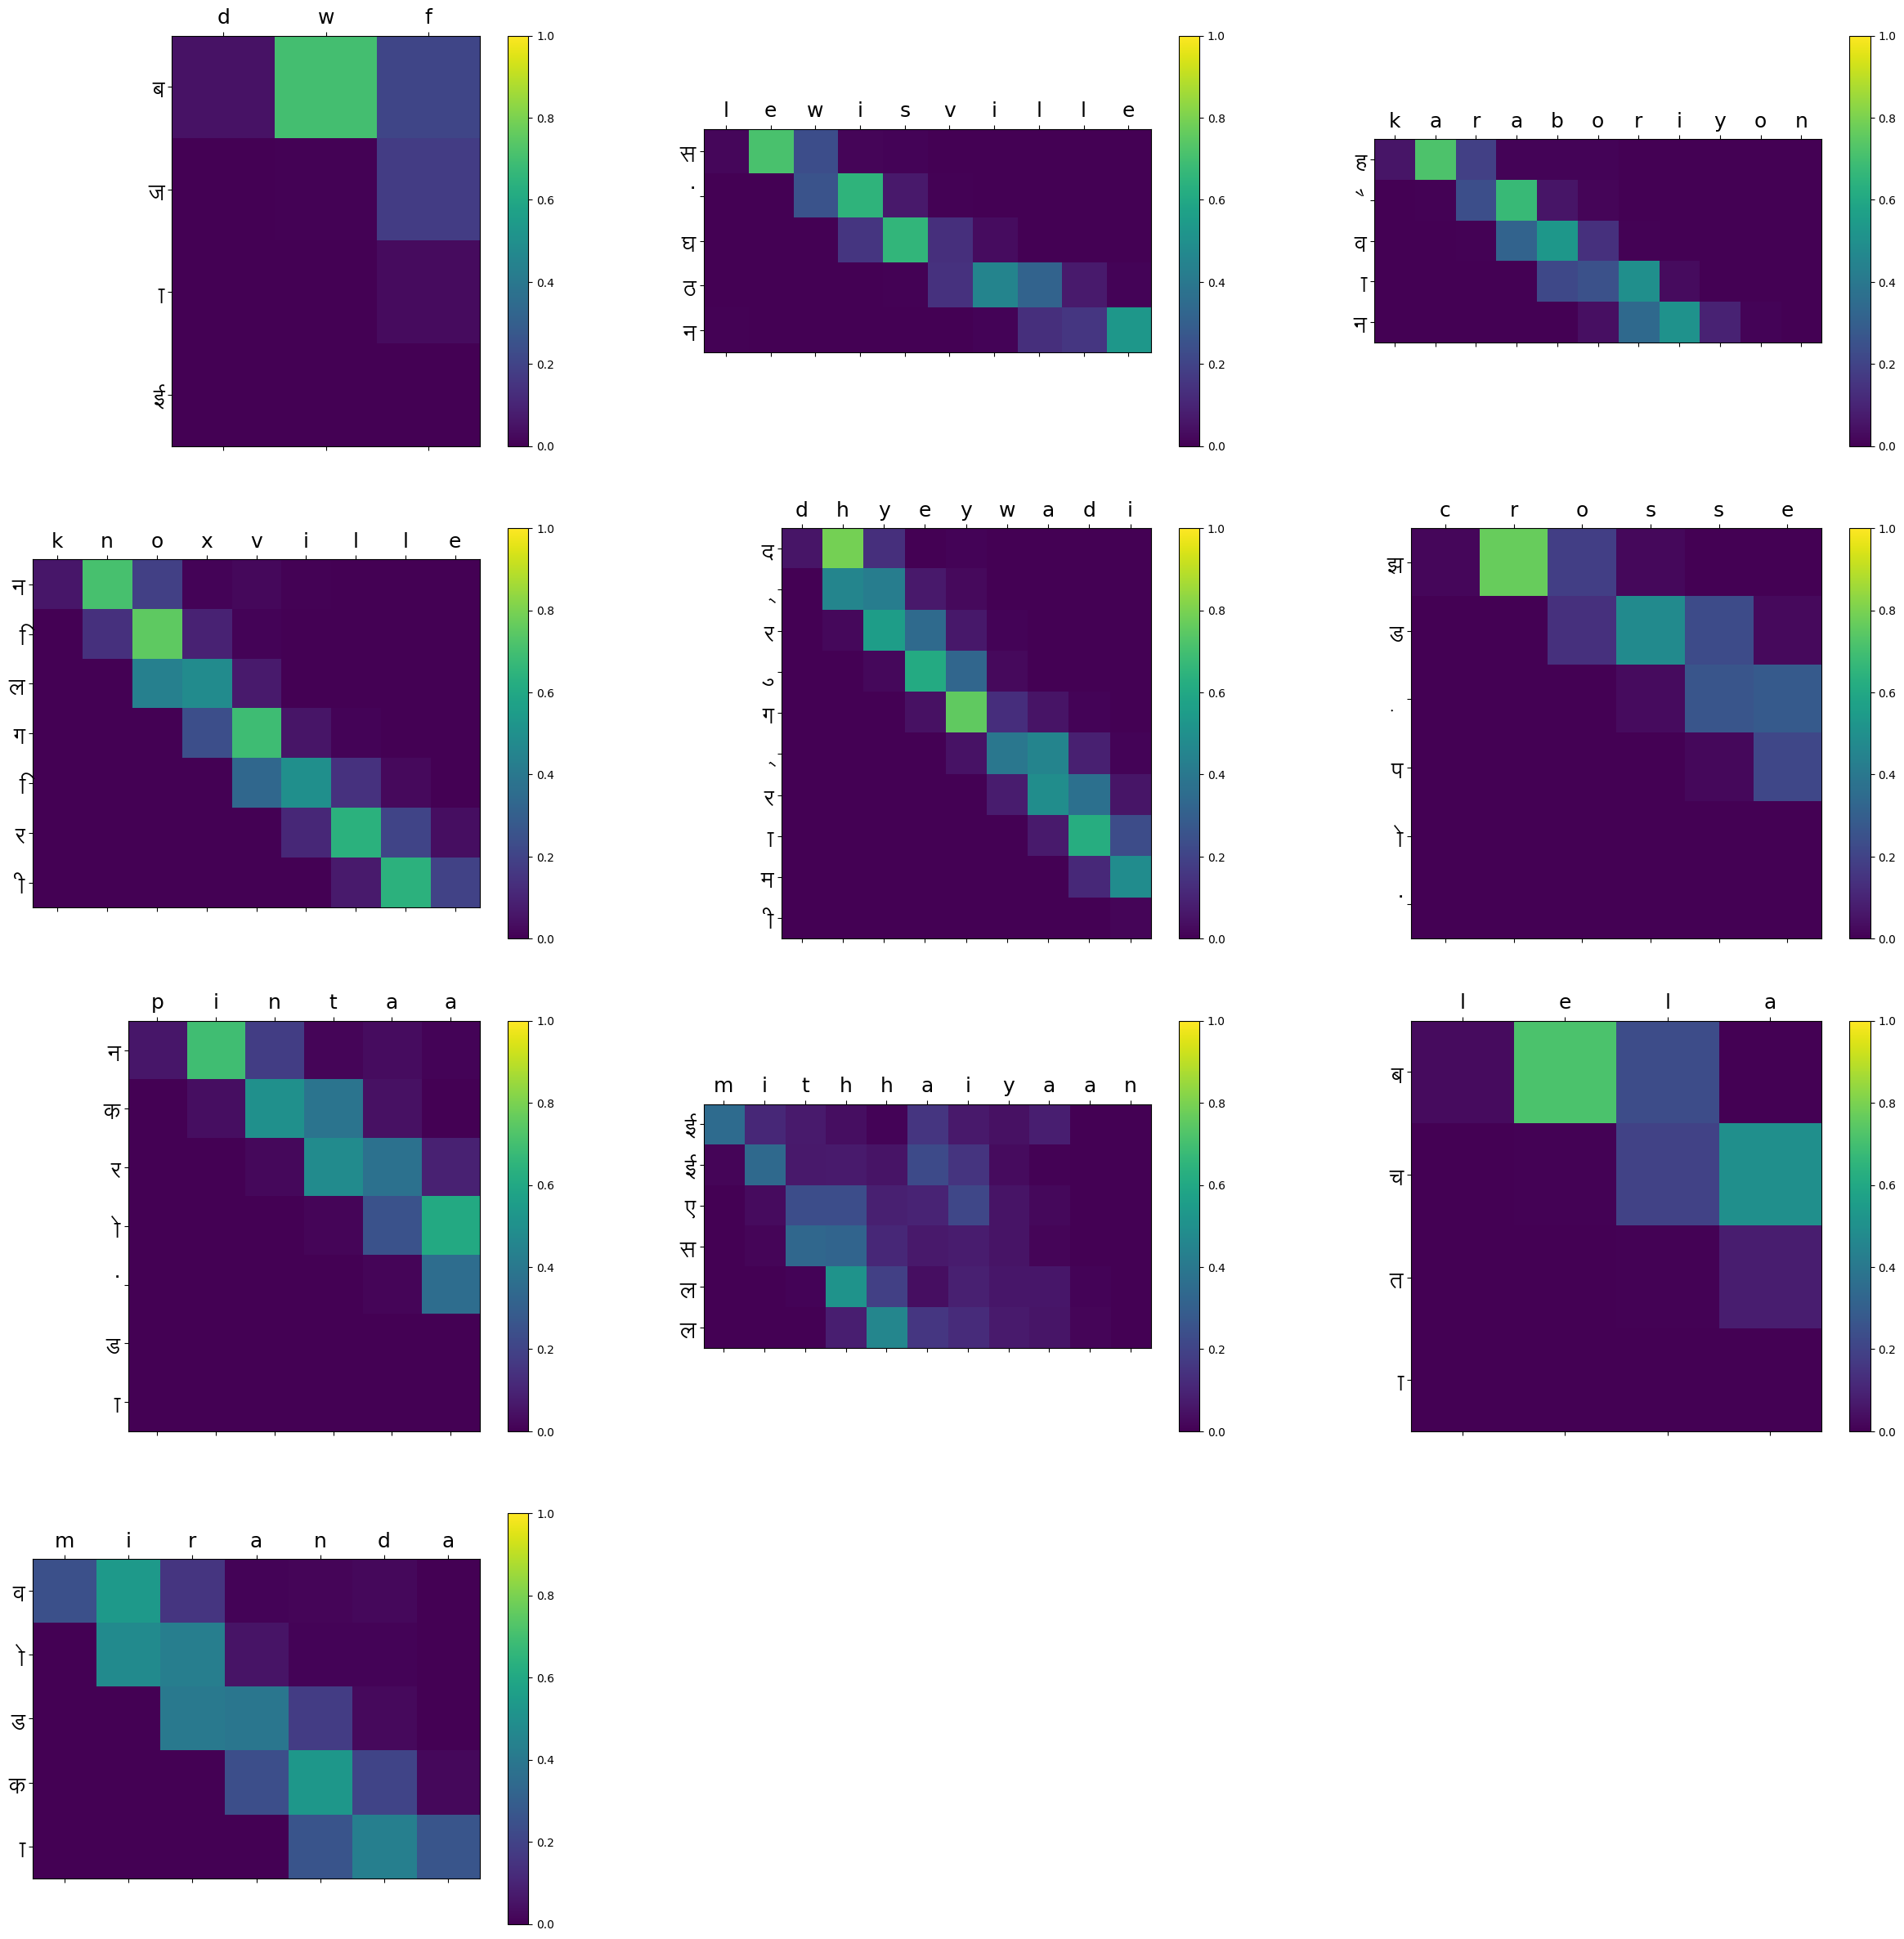

In [73]:
from matplotlib.font_manager import FontProperties
np.random.seed(10)
fig = plt.figure(figsize=(30, 30))
for i in range(10):
    seq_index = np.random.randint(len(test_X))
    input_seq = test_X[seq_index]
    plot_heatmap(model, input_seq, input_char_index, output_char_index, reverse_input_char_index, 
              reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
              num_encoder_tokens, num_decoder_tokens, device, fig, i+1)
    
    # visualize(model, input_seq, input_char_index, output_char_index, reverse_input_char_index, 
    #           reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
    #           num_encoder_tokens, num_decoder_tokens, device)
    
    print("\n")